<a href="https://colab.research.google.com/github/arangodb/interactive_tutorials/blob/master/notebooks/ArangoDB_NetworkX_Interface_Introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook will illustrate how the Networkx adapter can be used to perform graph analytics tasks on graph data stored in ArangoDB. This is a summarized version of the notebook focusing more on introducing the ArangoDB NetworkX adapter. For this example we will use the IMDB movie review dataset. The dataset provides reviews of various movies by viewers. The details of the dataset are available [here](https://www.imdb.com/interfaces/). 

The illustration in this notebook is organized as follows:
1. Loading the data for the example.
2. Creating the Networkx graph from the AranogoDB graph using the Networkx Adapter.
3. Analysis of the centrality measure of the graph using Networkx.
4. Store the experiment with arangopipe

In [ ]:
%%capture
!mkdir oasis
!mkdir data
!git clone -b imdb_with_ratings https://github.com/arangodb/interactive_tutorials data
!git clone -b oasis_connector https://github.com/arangodb/interactive_tutorials oasis
!rsync -av oasis/ ./ --exclude=.git
!chmod -R 755 ./data
!chmod -R 755 ./tools
!chmod -R 755 ./oasis

!pip3 install networkx
!pip3 install matplotlib
!pip3 install adbnx-adapter
!pip3 install pyarango
!pip3 install python-arango
!pip install arangopipe==0.0.6.9.3

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import numpy as np

In [ ]:
from adbnx_adapter.imdb_arangoDB_networkx_adapter import IMDBArangoDB_Networkx_Adapter
import oasis
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import numpy as np



con = oasis.getTempCredentials()

# Connect to the temp database
conn = oasis.connect(con)
db = conn[con["dbName"]]

print()
print("https://{}:{}".format(con["hostname"], con["port"]))
print("Username: " + con["username"])
print("Password: " + con["password"])
print("Database: " + con["dbName"])

Requesting new temp credentials.
Temp database ready to use.

https://tutorials.arangodb.cloud:8529
Username: TUTdsh8f6kolfhspa2aliabl
Password: TUT659t57m73r4jw7362riudg
Database: TUTt9ibvv50ela7bgood04fzm


In [ ]:
# Use the new ArangoDB connection with the NetworkX adapter.

ma = IMDBArangoDB_Networkx_Adapter(conn=con)

In [ ]:
! ./tools/arangorestore -c none --server.endpoint http+ssl://{con["hostname"]}:{con["port"]} --server.username {con["username"]} --server.database {con["dbName"]} --server.password {con["password"]} --default-replication-factor 3  --input-directory "./data/data/imdb_with_ratings"

In [ ]:
from pyArango.connection import *
from pyArango.collection import Collection, Edges, Field
from pyArango.graph import Graph, EdgeDefinition

class Users(Collection):
    _fields = {
        "user_id": Field(),
        "age": Field(),
        "gender": Field()
    }
    
class Movies(Collection):
    _fields = {
        "movie_id": Field(),
        "movie_title": Field(),
        "release_data": Field()
    }

class Ratings(Edges): 
    _fields = {
        #user_id and movie_id (_key of movie) are encoded by _from, _to 
        "rating": Field(),
        "timestamp": Field()
    }

class IMDBGraph(Graph):
    _edgeDefinitions = [EdgeDefinition("Ratings", fromCollections=["Users"], toCollections=["Movies"])]
    _orphanedCollections = []

iMDBGraph = db.createGraph("IMDBGraph", replicationFactor=3)

print("Collection/Graph Setup done.")

Collection/Graph Setup done.


# Use the Networkx-Adapter to create a Networkx Graph

Now that we have loaded the data into ArangoDB, we can use the __Networkx-Adapter__ to create _Networkx_ graphs from the ArangoDB graph. To do so, we'll have to provide a graph descriptor that describes the graph structure to the __Networkx-Adapter__. These steps are illustrated below. 

## Specify the Graph Structure

To use the IMDB Networkx Adapter, we need to specify the structure of the graph that we want to create. This is done with a simple dictionary. 

In [ ]:
imdb_attributes = {'vertexCollections': {'Users': {},
                                         'Movies': {}},
                   'edgeCollections': {'Ratings': {'_from', '_to', 'ratings'}}}

## Obtain the networkx graph

In [ ]:
g = ma.create_networkx_graph(
    graph_name='IMDBGraph',  graph_attributes=imdb_attributes)

__Done!__, we now have a _Networkx_ graph representation that we can use for analysis!

# Analysis of the IMDB reviews dataset with Networkx
We just created a networkx graph for this problem. In this notebook we will use a small set of ideas from the standard body of ideas used in network analysis to extract insights from the movie review dataset. Networkx provides an implementation of these ideas. These will be discussed next.

As mentioned earlier, one of the advantages of using a graph representation is that we can leverage the standard body of ideas used to analyze networks to extract information about this dataset. In what follows, we will call out such facts as we identify them.

## Get the user and movie nodes

In [ ]:
user_nodes = [n for n in g.nodes() if n.startswith("Users")]
movie_nodes = [n for n in g.nodes() if n.startswith("Movies")]

## Structural Property Introspection: Number of Nodes and Edges

In [ ]:
print("Number of Users are %d" % (len(user_nodes)))
print("Number of Movies are %d" % (len(movie_nodes)))
print("Number of Ratings are %d" % (len(list(g.edges()))))

Number of Users are 943
Number of Movies are 1682
Number of Ratings are 65499


## Convert the graph obtained from the interface to a bi-partite graph 

In [ ]:
B = nx.Graph()
B.add_nodes_from(user_nodes, bipartite=0)
B.add_nodes_from(movie_nodes, bipartite=1)
B.add_edges_from(list(g.edges()))

### Identified fact:
_The graph has two kinds of edges. It has 943 users and and 1682 Movies. A user may watch multiple movies. 65499 movie ratings are available. This information is obtained by simply identifying the structure of the graph._

In [ ]:
from networkx.algorithms import bipartite
bipartite.is_bipartite(B)

True

## Is the graph connected?
If the graph is connected then there is a path between any two nodes in the graph. If not, then some nodes are not connected. In the context of this application, a disconnected graph implies that there exist users in the graph who may not have rated a movie in common. If it is true that any given pair of users have rated at least one movie in common, then there is a path connecting these users through the movie they have rated in common.

## Identified fact:
_In the user community, if we pick any two users, then it is possible that they may not have rated a movie in common._

In [ ]:
nx.is_connected(B)

False

In [ ]:
users = [n for n in B.nodes if B.nodes[n]['bipartite'] == 0]
movies = [n for n in B.nodes if B.nodes[n]['bipartite'] == 1]

## Centrality Measures

A centrality measure identifies influential nodes in a network. How do we formalize the observations about movie importance and the user's rating behavior in the given network? The notion of centrality measure is useful in this regard. Many measures of node centrality are used, see [Chapter 3 of the text book by Zafarani et.al](http://dmml.asu.edu/smm/) for details. We will use degree centraility in this example (see the [documentation](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.bipartite.centrality.degree_centrality.html) for details). In the illustrations below, we will capture the top 10 users and movies in terms of importance as determined by this measure. 

In [ ]:
dc= bipartite.degree_centrality(B, users)
sdcu = {}
sdcm = {}
for k, v in sorted(dc.items(),reverse=True, key=lambda item: item[1]):
    if k.startswith("Users"):
        sdcu[k] = v
    else:
        sdcm[k] = v

del dc

## List the top 10 users in terms of degree centrality
These guys rate a lot of movies

In [ ]:
list(sdcu.keys())[:10]

['Users/405',
 'Users/13',
 'Users/276',
 'Users/450',
 'Users/234',
 'Users/303',
 'Users/416',
 'Users/655',
 'Users/181',
 'Users/393']

## How does this importance measure vary over the user community?
We can get a sense of this by viewing the distribution of this measure.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'User Degree Centraility')

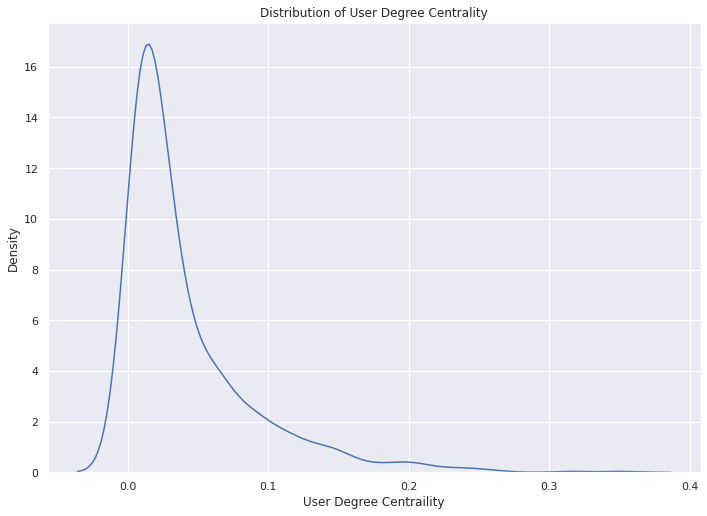

In [ ]:
npvals = np.fromiter(sdcu.values(), dtype=float)
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.distplot(npvals, hist = False)
plt.title("Distribution of User Degree Centrality")
plt.xlabel("User Degree Centraility")

## How does this importance measure vary over the movie community?

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Movie Degree Centraility')

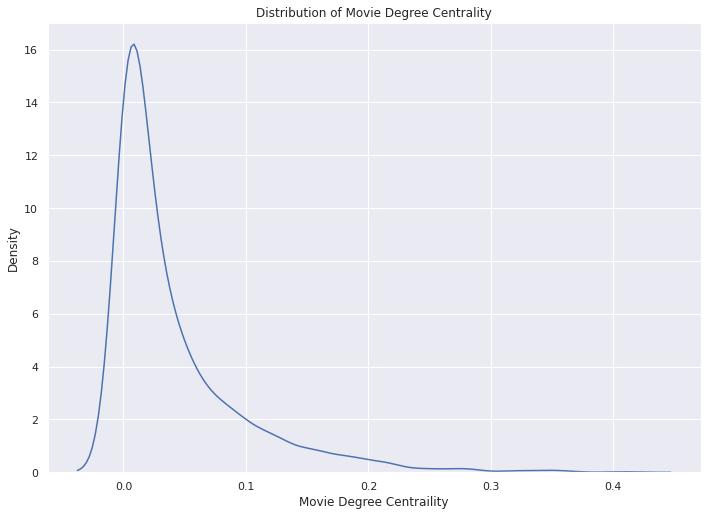

In [ ]:
npvals = np.fromiter(sdcm.values(), dtype=float)
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.distplot(npvals, hist = False)
plt.title("Distribution of Movie Degree Centrality")
plt.xlabel("Movie Degree Centraility")

### Identified fact:
_We have a measure to capture the importance of a movie and a user on the basis of the rating activity performed on them. We have identified important users and movies in the network on the basis of this measure. We have also have information about how this importance measure varies over the users and movies in the data._

In [ ]:
m4v = [t[0] for t in g.in_edges('Movies/4')]
from itertools import combinations
m4vucmb = list(combinations(m4v, 2))

In [ ]:
import networkx as nx
gp = g.to_undirected()
jcp = nx.jaccard_coefficient(gp, m4vucmb)

In [ ]:
jcpv = []
for u, v, p in jcp:
    jcpv.append(p)
    #print('(%s, %s) -> %.8f' % (u, v, p))

This is a snippet of the above commented out print statement showing the similarity between users who viewed the film Get Shorty.
```
(Users/562, Users/222) -> 0.06358382
(Users/562, Users/264) -> 0.04697987
(Users/562, Users/712) -> 0.05128205
(Users/562, Users/279) -> 0.04427083
(Users/562, Users/16) -> 0.11184211
(Users/562, Users/385) -> 0.08171206
(Users/562, Users/198) -> 0.11864407
```



# Store metadata about these experiments using Arangopipe

In [ ]:
from arangopipe.arangopipe_storage.arangopipe_api import ArangoPipe
from arangopipe.arangopipe_storage.arangopipe_admin_api import ArangoPipeAdmin
from arangopipe.arangopipe_storage.arangopipe_config import ArangoPipeConfig
from arangopipe.arangopipe_storage.managed_service_conn_parameters import ManagedServiceConnParam
mdb_config = ArangoPipeConfig()
msc = ManagedServiceConnParam()
conn_params = { msc.DB_SERVICE_HOST : "arangoml.arangodb.cloud", \
                        msc.DB_SERVICE_END_POINT : "createDB",\
                        msc.DB_SERVICE_NAME : "createDB",\
                        msc.DB_SERVICE_PORT : 8529,\
                        msc.DB_CONN_PROTOCOL : 'https'}
        
mdb_config = mdb_config.create_connection_config(conn_params)
admin = ArangoPipeAdmin(reuse_connection = False, config = mdb_config)
ap_config = admin.get_config()
ap = ArangoPipe(config = ap_config)
proj_info = {"name": "IMDB_Movie_Reviews"}
proj_reg = admin.register_project(proj_info)
print(" ")
print("Your temporary arangopipe database can be accessed using the following credentials:")
mdb_config.get_cfg()

API endpoint: https://arangoml.arangodb.cloud:8529/_db/_system/createDB/createDB


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Host Connection: https://arangoml.arangodb.cloud:8529
 
Your temporary arangopipe database can be accessed using the following credentials:


{'arangodb': {'DB_end_point': 'createDB',
  'DB_service_host': 'arangoml.arangodb.cloud',
  'DB_service_name': 'createDB',
  'DB_service_port': 8529,
  'arangodb_replication_factor': None,
  'conn_protocol': 'https',
  'dbName': 'MLjvn54vmf8vp9arajrb0cx',
  'password': 'MLtis4hwsj62gt7604o6ee',
  'username': 'MLbcb3ylov96mhthmyvappyq'},
 'mlgraph': {'graphname': 'enterprise_ml_graph'}}

In [ ]:
import io
import requests
url = ('https://raw.githubusercontent.com/arangoml/networkx-adapter/master/examples/IMDB_Networkx_Adapter.ipynb')
nbjson = requests.get(url).text
model_info = {"name": "Exploratory Data Analysis IMDB",  "task": "multiple", 'notebook': nbjson}
model_reg = ap.register_model(model_info, project = "IMDB_Movie_Reviews")

## Summary 
* The Networkx-Adapter makes it easy to obtain Networkx graphs from ArangoDB graphs.
* We have demonstrated that using a graph representation helped us identify facts about the data. These facts were identified by leveraging standard ideas from Network Theory.
* We have leveraged the Networkx graph to obtain a _Node2vec_ embedding of the graph associated with our data. For an example of how the Networkx-Adapter can be used with a _deep learning_ library, please view the [ITSM ArangoDB Adapter](https://github.com/arangoml/networkx-adapter/blob/master/examples/ITSM_ArangoDB_Adapter.ipynb).    